Online property companies offer valuations of houses using machine learning techniques. The aim of this report is to predict the house sales in King County, Washington State, USA using Multiple Linear Regression (MLR). The dataset consisted of historic data of houses sold between May 2014 to May 2015.


Sale prediction of houses in King County with an accuracy of at least 75-80% and understand which factors are responsible for higher property value - $650K and above.”


The dataset consists of house prices from King County an area in the US State of Washington, this data also covers Seattle. The dataset was obtained from Kaggle. This data was published/released under CC0: Public Domain. Unfortunately, the user has not indicated the source of the data. Please find the citation and database description in the Glossary and Bibliography.

## Importing required libraries

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.neighbors import KNeighborsRegressor

In [58]:
sns.set_theme(style="whitegrid")

In [59]:
data = pd.read_csv("kc-house-data\kc_house_data.csv")

In [60]:
df = data.copy()

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21611 non-null  float64
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [62]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180.0,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170.0,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770.0,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050.0,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680.0,0,1987,0,98074,47.6168,-122.045,1800,7503


Formating the Date column

In [63]:
# converting to date
df['date'] = pd.to_datetime(df['date'], format='%Y%m%dT%H%M%S')

Splitting the date into year, month and day. So it can be used as a feature to train model.

In [64]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

#### Checking for any duplicates rocords

In [65]:
df.duplicated().sum()

0

#### Checking for any missing values

In [66]:
df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       2
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
year             0
month            0
day              0
dtype: int64

We can observer that we have 2 missing values in the feature *sqft_above*

In [67]:
# Fetching the index of the record where 'sqft_above' is null and 
# then parsing it to iloc to fetch the whole record so we can drop it.
df.iloc[df[df['sqft_above'].isnull()].index,:]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
10,1736800520,2015-04-03,662500.0,3,2.5,3560,9796,1.0,0,0,...,1965,0,98007,47.6007,-122.145,2210,8925,2015,4,3
17,6865200140,2014-05-29,485000.0,4,1.0,1600,4300,1.5,0,0,...,1916,0,98103,47.6648,-122.343,1610,4300,2014,5,29


Since there are only 2 records with missing values which less than the 5% of the length of the dataset, we can remove these records.

In [68]:
# Removing the record with nan values
df.drop([10,17],inplace = True)

Let us look into the correlation heatmap to understand the relationship of all the features with price.

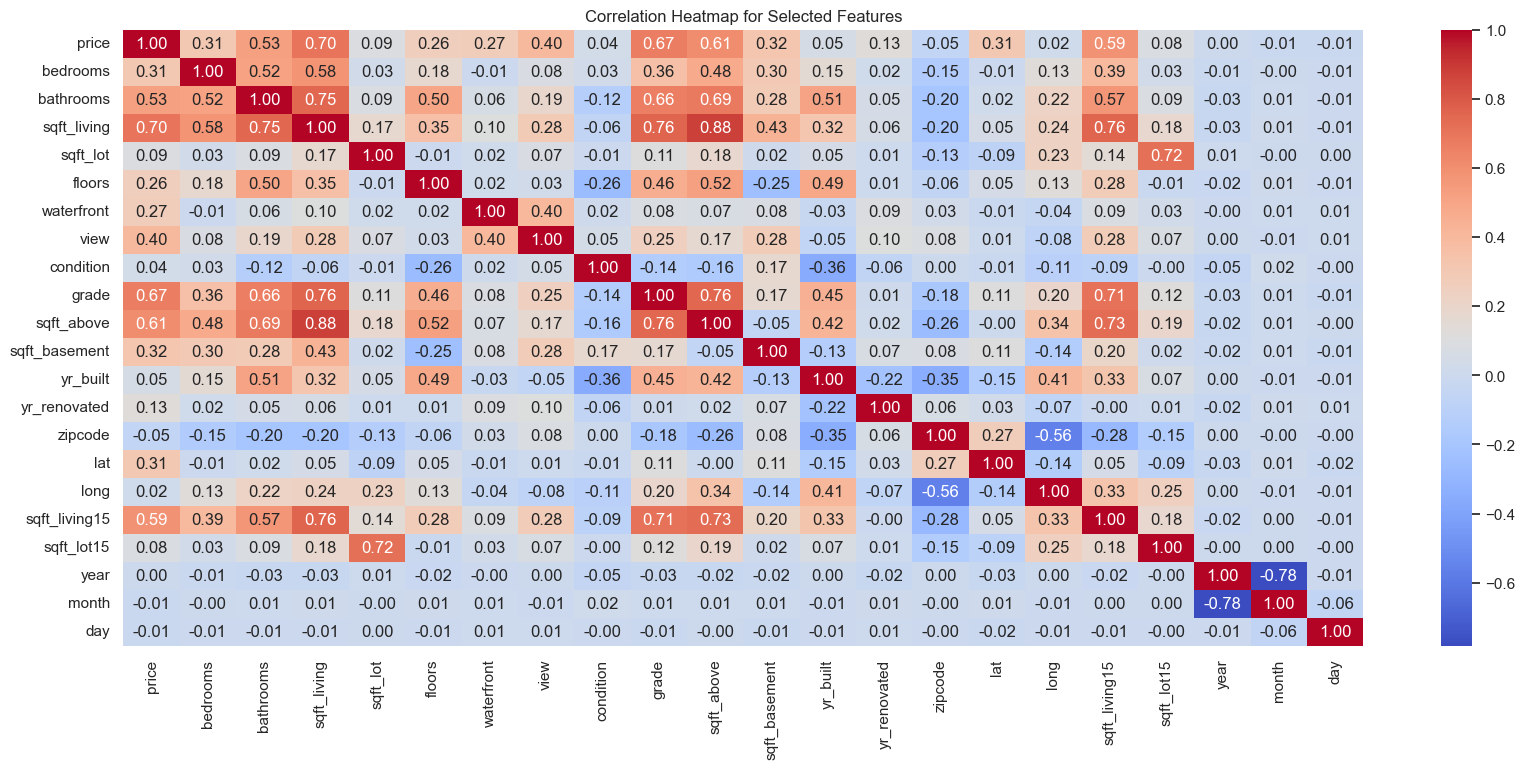

In [69]:
# Correlation matrix can only be created between numerics features
# Creating a list of numeric features
cols_of_interest = ['price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'year', 'month', 'day']

# The correlation Matrix
correlation_matrix = df[cols_of_interest].corr()

# Creating the figure of plot the heatmap
plt.figure(figsize=(20, 8))

# Creating the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

# Adding labels and title
plt.title('Correlation Heatmap for Selected Features')
plt.show()

Looking at coorelation heatmap, we can select the features that we can use the train the model.

1. bedrooms
2. bathrooms
3. sqft_living
4. grade
5. sqft_above
6. sqft_living15
 

Now let's look for irregularities in the feature that we have selected to work with. 

Analyzing the ***bedrooms*** feature 

In [70]:
# Fetching the unique values and the frequency of each.
df['bedrooms'].value_counts()

bedrooms
3     9823
4     6881
2     2760
5     1601
6      272
1      199
7       38
0       13
8       13
9        6
10       3
11       1
33       1
Name: count, dtype: int64

<Axes: >

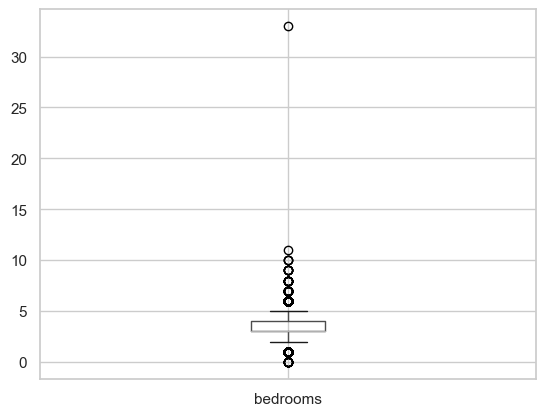

In [71]:
df.boxplot(column="bedrooms")

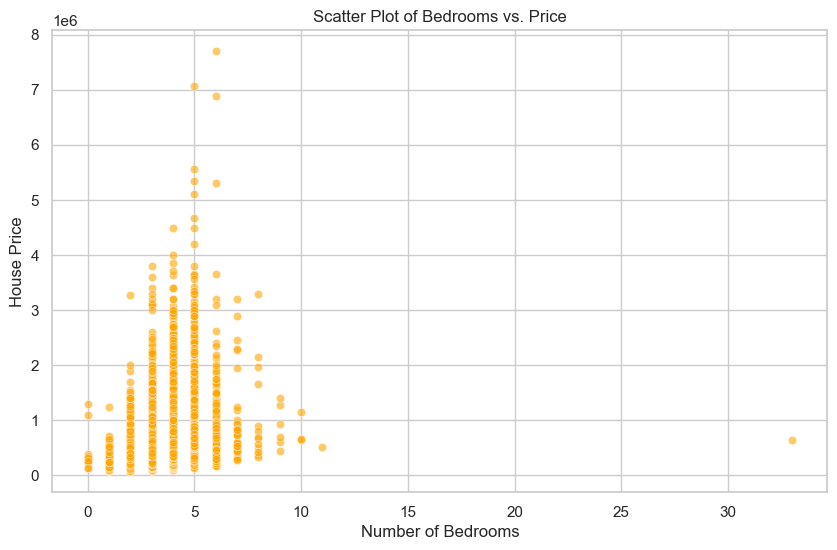

In [72]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='bedrooms', y='price', alpha=0.6, color="orange")

plt.xlabel('Number of Bedrooms')
plt.ylabel('House Price')
plt.title('Scatter Plot of Bedrooms vs. Price')
plt.show()

We can observer that bedrooms feature contains unrealistic values that are extreme or unlikely in a typical housing dataset, particularly when the distribution of bedrooms becomes sparse at higher counts. 

* Based on the distribution we can say bedrooms above 7 or 8 are quite rare.

* the value 0, represents **error** or **studio apartments**.

for this analysis we are removing the all the records with number of bedrooms 0 or greater then 8

In [73]:
# Filtering the records where the bedrooms is greater or equal to 1 
# and values which are smaller or equal to 8

# Created a new DataFrame where we will apply all the filters.
df_filtered = df.query("bedrooms >= 1 and bedrooms <= 8")

Analyzing the ***bathrooms*** feature

In [74]:
df_filtered['bathrooms'].value_counts()

bathrooms
2.50    5376
1.00    3850
1.75    3047
2.25    2047
2.00    1929
1.50    1445
2.75    1185
3.00     749
3.50     731
3.25     589
3.75     155
4.00     135
4.50      98
4.25      79
0.75      71
4.75      23
5.00      21
5.25      12
5.50      10
1.25       9
6.00       6
0.50       4
5.75       4
0.00       3
6.75       2
8.00       2
6.25       2
6.50       2
7.75       1
Name: count, dtype: int64

<Axes: >

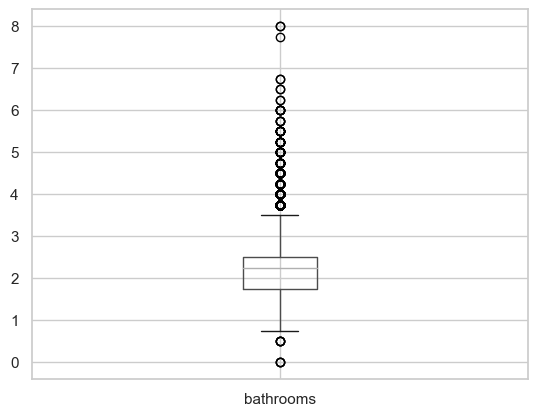

In [75]:
df_filtered.boxplot(column="bathrooms")

<Axes: >

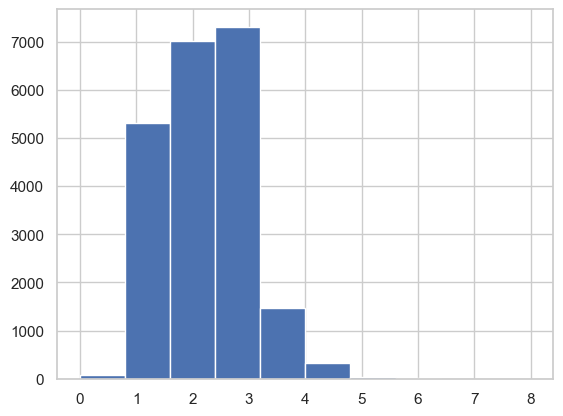

In [76]:
df_filtered['bathrooms'].hist()

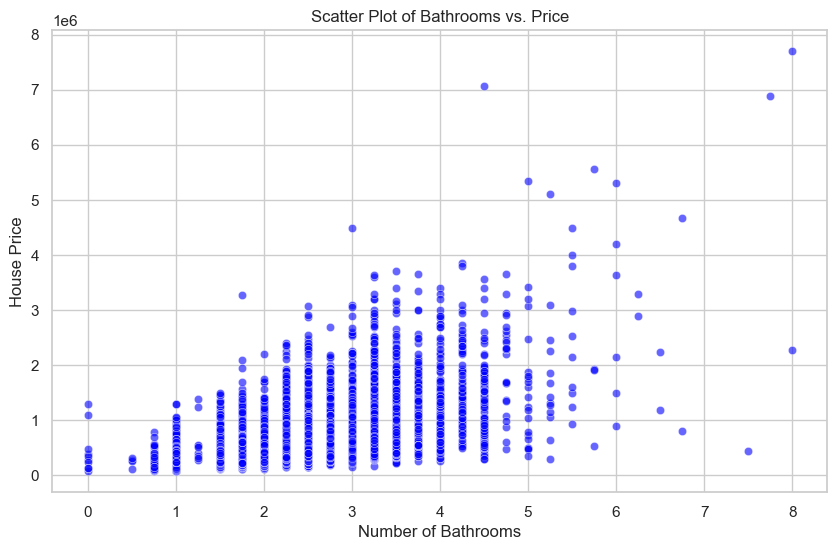

In [77]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='bathrooms', y='price', alpha=0.6, color="blue")

plt.xlabel('Number of Bathrooms')
plt.ylabel('House Price')
plt.title('Scatter Plot of Bathrooms vs. Price')
plt.show()

The ***bathrooms*** feature has some anomalies too.

* Properties with 0 bathrooms are likely to a data entry error.
* Bathrooms above 5 becomes quite rare, also with very few occurrences in the distribution show and it introduces skewness.

After analyzing the result we remove the records with 0 bathrooms and any records with more then 5 bathrooms.

In [78]:
df_filtered = df_filtered[(df_filtered['bathrooms'] >= 1) & (df_filtered['bathrooms'] <= 5)]

Analyzing the ***sqft*** features

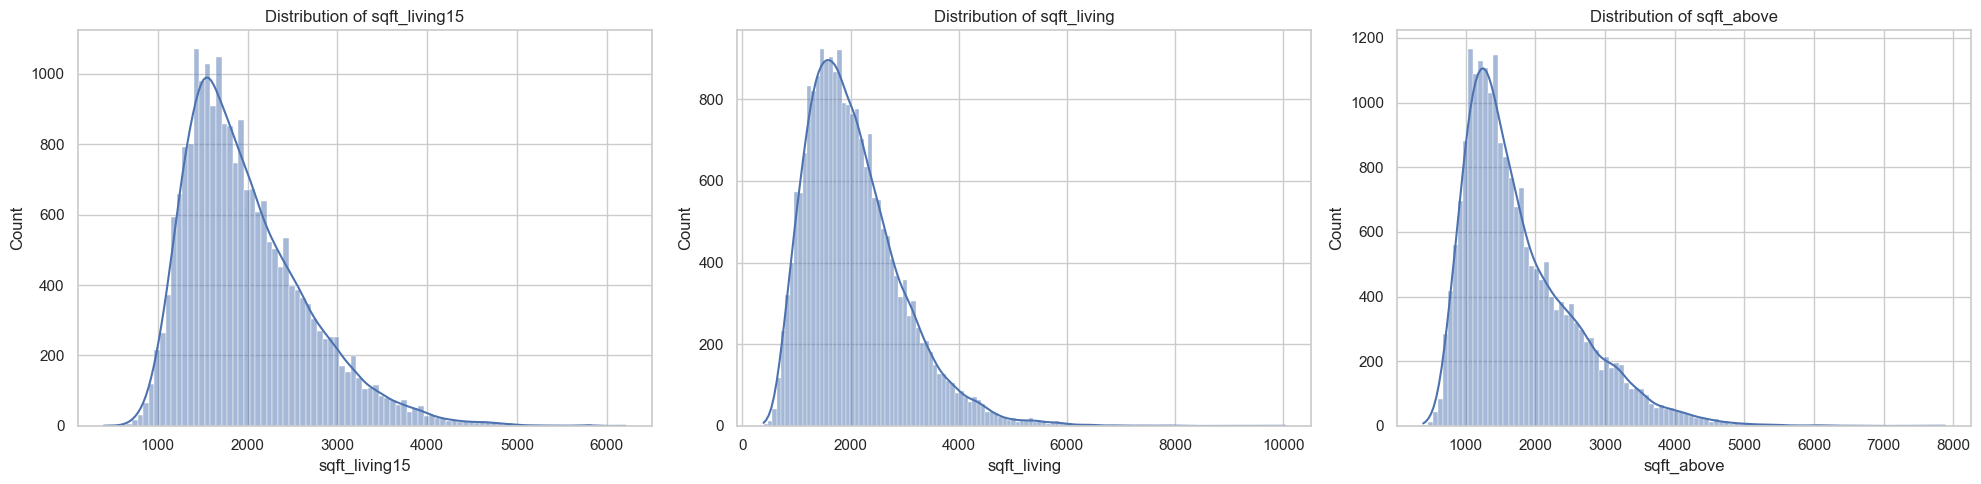

In [79]:
plt.figure(figsize=(20, 5))

# First subplot
plt.subplot(1, 3, 1)
sns.histplot(df_filtered['sqft_living15'], kde=True)
plt.title('Distribution of sqft_living15')

# Second subplot
plt.subplot(1, 3, 2)
sns.histplot(df_filtered['sqft_living'], kde=True)
plt.title('Distribution of sqft_living')

# Third subplot
plt.subplot(1, 3, 3)
sns.histplot(df_filtered['sqft_above'], kde=True)
plt.title('Distribution of sqft_above')

plt.tight_layout()
plt.show()

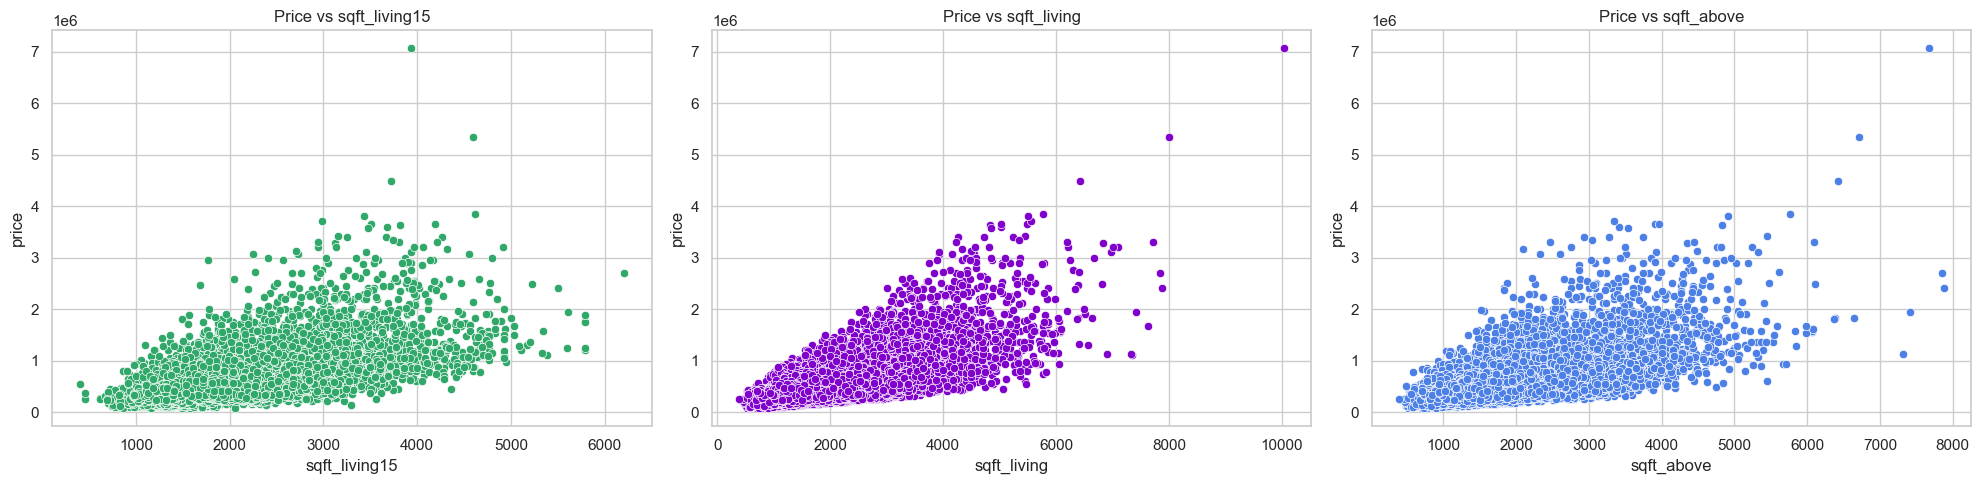

In [80]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), tight_layout=True)

# Plot sqft_living15 vs price
sns.scatterplot(x='sqft_living15', y='price', data=df_filtered, ax=axes[0], color=(0.188, 0.66, 0.413))
axes[0].set_title('Price vs sqft_living15')

# Plot sqft_living vs price
sns.scatterplot(x='sqft_living', y='price', data=df_filtered, ax=axes[1], color=(0.5, 0, 0.8))
axes[1].set_title('Price vs sqft_living')

# Plot sqft_above vs price
sns.scatterplot(x='sqft_above', y='price', data=df_filtered, ax=axes[2], color=(0.3, 0.5, 0.9))
axes[2].set_title('Price vs sqft_above')

plt.show()

All of these 3 feature shows some level of skewness to it.

To deal with this issue we can use the ***log-transformation*** method. 

In [81]:
# Log-transform the selected features
df_filtered['log_sqft_living15'] = np.log1p(df_filtered['sqft_living15'])
df_filtered['log_sqft_living'] = np.log1p(df_filtered['sqft_living'])
df_filtered['log_sqft_above'] = np.log1p(df_filtered['sqft_above'])

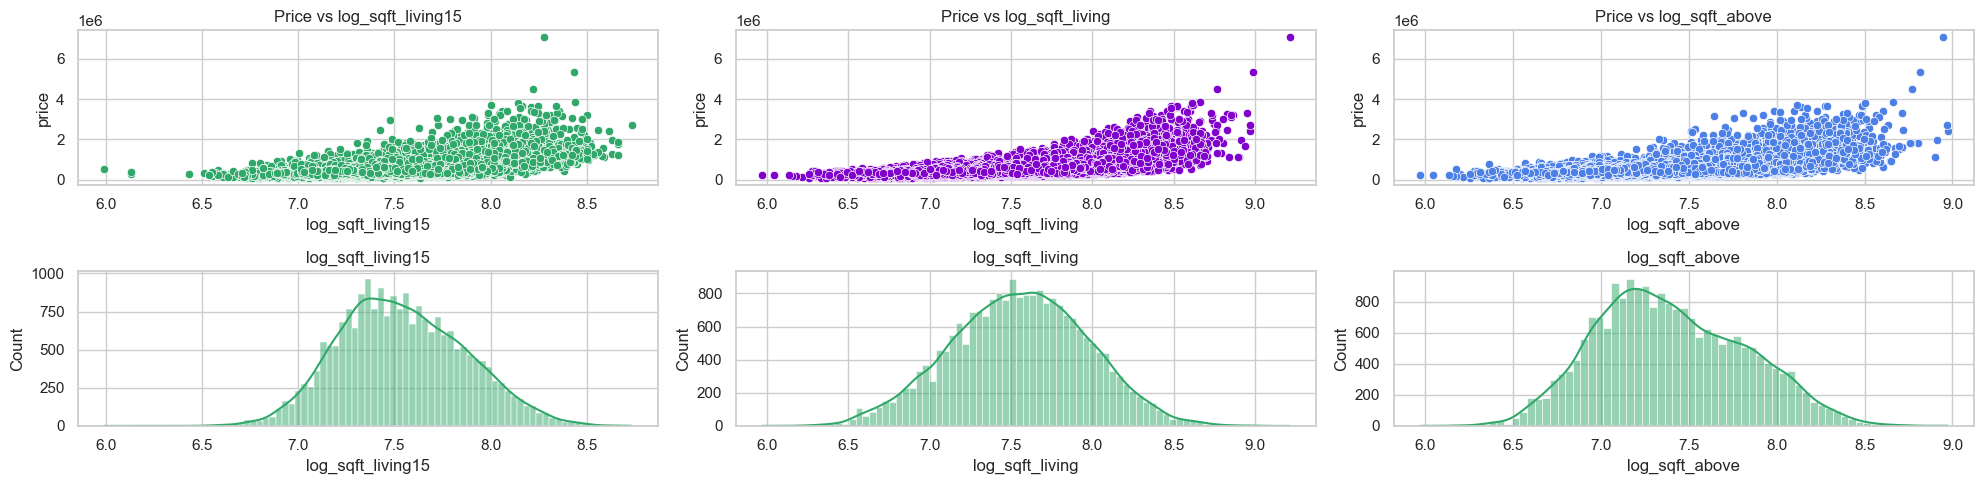

In [82]:
fig, axes = plt.subplots(2, 3, figsize=(20, 5), tight_layout=True)

# Plot log_sqft_living15 vs price
sns.scatterplot(x='log_sqft_living15', y='price', data=df_filtered, ax=axes[0][0], color=(0.188, 0.66, 0.413))
axes[0][0].set_title('Price vs log_sqft_living15')

# Plot log_sqft_living vs price
sns.scatterplot(x='log_sqft_living', y='price', data=df_filtered, ax=axes[0][1], color=(0.5, 0, 0.8))
axes[0][1].set_title('Price vs log_sqft_living')

# Plot log_sqft_above vs price
sns.scatterplot(x='log_sqft_above', y='price', data=df_filtered, ax=axes[0][2], color=(0.3, 0.5, 0.9))
axes[0][2].set_title('Price vs log_sqft_above')


sns.histplot(df_filtered['log_sqft_living15'], kde=True, ax=axes[1][0], color=(0.188, 0.66, 0.413))
axes[1][0].set_title('log_sqft_living15')

sns.histplot(df_filtered['log_sqft_living'], kde=True, ax=axes[1][1], color=(0.188, 0.66, 0.413))
axes[1][1].set_title('log_sqft_living')

sns.histplot(df_filtered['log_sqft_above'], kde=True, ax=axes[1][2], color=(0.188, 0.66, 0.413))
axes[1][2].set_title('log_sqft_above')

plt.show()

After observing the scatter plot of price vs log_sqft features, it seems perform a log-transformation on out targer variable is also needed.

Befor fore performing the transformation let us look at the distribution of the price variable.

<Axes: xlabel='price', ylabel='Count'>

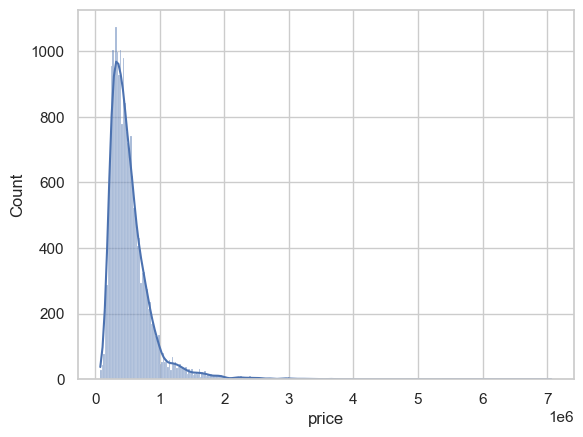

In [83]:
sns.histplot(df_filtered['price'], kde=True)

In [84]:
# log-transforming the price variable.
df_filtered['log_price'] = np.log1p(df_filtered['price'])

Let us again visualizise the scatter plot of log_price vs log_sqfts

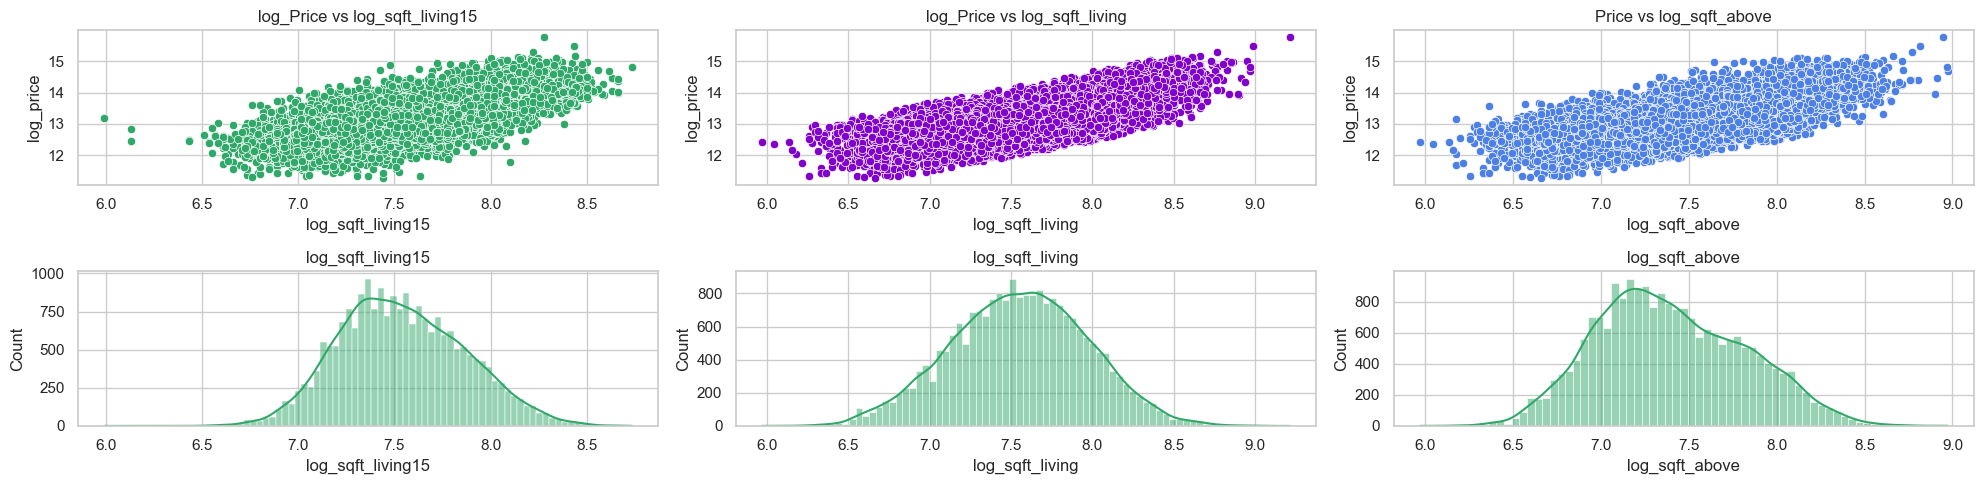

In [85]:
fig, axes = plt.subplots(2, 3, figsize=(20, 5), tight_layout=True)

# Plot log_sqft_living15 vs log_price
sns.scatterplot(x='log_sqft_living15', y='log_price', data=df_filtered, ax=axes[0][0], color=(0.188, 0.66, 0.413))
axes[0][0].set_title('log_Price vs log_sqft_living15')

# Plot log_sqft_living vs log_price
sns.scatterplot(x='log_sqft_living', y='log_price', data=df_filtered, ax=axes[0][1], color=(0.5, 0, 0.8))
axes[0][1].set_title('log_Price vs log_sqft_living')

# Plot log_sqft_above vs log_price
sns.scatterplot(x='log_sqft_above', y='log_price', data=df_filtered, ax=axes[0][2], color=(0.3, 0.5, 0.9))
axes[0][2].set_title('Price vs log_sqft_above')


sns.histplot(df_filtered['log_sqft_living15'], kde=True, ax=axes[1][0], color=(0.188, 0.66, 0.413))
axes[1][0].set_title('log_sqft_living15')

sns.histplot(df_filtered['log_sqft_living'], kde=True, ax=axes[1][1], color=(0.188, 0.66, 0.413))
axes[1][1].set_title('log_sqft_living')

sns.histplot(df_filtered['log_sqft_above'], kde=True, ax=axes[1][2], color=(0.188, 0.66, 0.413))
axes[1][2].set_title('log_sqft_above')

plt.show()

<Axes: xlabel='grade', ylabel='Count'>

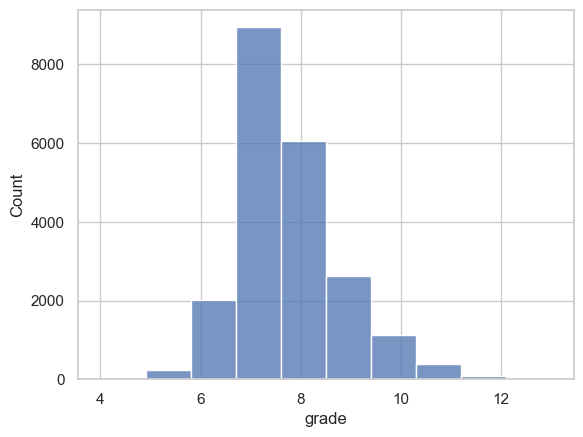

In [86]:
sns.histplot(df_filtered['grade'], bins=10)

# **Multiple Linear Regression**

Now let us split our dataset into train and test so we can train ***the Multiple Linear Regression Model.***

In [87]:
# Before spliting the dataframe, let us keep only the feature that are required.
df_model = df_filtered.loc[:,['log_price', 'bedrooms', 'bathrooms', 'grade', 'log_sqft_living15', 'log_sqft_living', 'log_sqft_above']]

Since grade is the categorical variables and it scales from 1 to 13, we will create the dummy variables for it.

In [88]:
df_model = pd.get_dummies(df_model, columns=['grade'], drop_first = False)

Splitting the Data in train and test.

In [89]:
# Drop the original 'log_price' column, as it is target variables
X = df_model.drop(['log_price'], axis=1) 
y = df_model['log_price']  # Target variable (price)

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Defining the Regression Model.

In [90]:
# model for Multiple Linear Regression
mlr = LinearRegression()

Fitting the training data which is standardized and log-transformed to the model.

the target variable is also in log form.

In [91]:
# Scaled and log feature, log targed variables.
mlr.fit(X_train, y_train)

LinearRegression()

***Before getting the Regression Summary we need to make sure that we inverse the log-transformation and standardization for the features and target variable.***

In [92]:
# Predicting the target variable price on train set
log_pred_y_train = mlr.predict(X_train)

# Reverse the log-transformation for predicted target variable 
normal_predicted_price_train = np.exp(log_pred_y_train)

# Reverse the log-transformation for training target variable
normal_y_train = np.exp(y_train)


# Prediting the target variable price on test set
log_pred_y_test = mlr.predict(X_test)

# Reverse the log-transformation for predicted target variable 
normal_predicted_price_test = np.exp(log_pred_y_test)

# Reverse the log-transformation for training target variable
normal_y_test = np.exp(y_test)

Evaluating the Performance of Multiple Linear Regression.

In [93]:
print("Regression Summary for Training set:")

# Calculate the metrics on the actual and predicted values
mae = mean_absolute_error(normal_y_train, normal_predicted_price_train)
rmse = np.sqrt(mean_squared_error(normal_y_train, normal_predicted_price_train))
r2 = r2_score(normal_y_train, normal_predicted_price_train)
mape = mean_absolute_percentage_error(normal_y_train, normal_predicted_price_train)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE) : {mape}')
print(f'R²: {r2}')

Regression Summary for Training set:
Mean Absolute Error (MAE): 147411.37888483724
Root Mean Squared Error (RMSE): 233160.8759368059
Mean Absolute Percentage Error (MAPE) : 0.2868613942215663
R²: 0.5531201334539819


Evaluating the model on testing set

In [94]:
print("Regression Summary for Testing set:")

# Calculate the metrics on the actual and predicted values
mae = mean_absolute_error(normal_y_test, normal_predicted_price_test)
rmse = np.sqrt(mean_squared_error(normal_y_test, normal_predicted_price_test))
r2 = r2_score(normal_y_test, normal_predicted_price_test)
mape = mean_absolute_percentage_error(normal_y_test, normal_predicted_price_test)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE) : {mape}')
print(f'R²: {r2}')

Regression Summary for Testing set:
Mean Absolute Error (MAE): 148575.74809381252
Root Mean Squared Error (RMSE): 228039.66896004218
Mean Absolute Percentage Error (MAPE) : 0.2903100345487758
R²: 0.56565381498985


### $R^2$

In [95]:
print("R squared for training set: ", r2_score(normal_y_train, normal_predicted_price_train))

print("R squared for testing set: ", r2_score(normal_y_test, normal_predicted_price_test))


R squared for training set:  0.5531201334539819
R squared for testing set:  0.56565381498985


**Predicting the prices of the two houses from test set.**

In [96]:
# selecting two records from test set
two_records = X_test[:2]
two_records

,bedrooms,bathrooms,log_sqft_living15,log_sqft_living,log_sqft_above,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13
3741,3,2.5,7.852050,7.871311,7.871311,False,False,False,True,False,False,False,False,False,False
17751,3,1.0,6.928538,6.769642,6.769642,False,False,True,False,False,False,False,False,False,False


Predicting the price for these two records.

In [97]:
# Predict log-transformed prices for these two records
log_two_predicted_prices = mlr.predict(two_records)

# Reverse the log transformation to get predicted prices in the original scale
two_predicted_prices = np.exp(log_two_predicted_prices)

# Get the actual prices for these two records and reverse log transformation
two_actual_log_prices = y_test[:2]
two_actual_prices = np.exp(two_actual_log_prices)

# Calculate the error for each record
errors = two_actual_prices - two_predicted_prices

# Display actual, predicted values, and errors
for i in range(2):
    print(f"Record {i+1}:")
    print(f"  Actual Price: {list(two_actual_prices)[i]:.2f}")
    print(f"  Predicted Price: {two_predicted_prices[i]:.2f}")
    print(f"  Error: {list(errors)[i]:.2f}\n")

Record 1:
  Actual Price: 672001.00
  Predicted Price: 462063.23
  Error: 209937.77

Record 2:
  Actual Price: 217001.00
  Predicted Price: 235078.74
  Error: -18077.74



# **KNN classification**

Standardizing the features

In [98]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Defining the knn model with ***k = 5***

In [99]:
# Initialize and fit the KNN model
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

KNeighborsRegressor()

In [100]:
# Predict on train set
knn_log_pred_y_train = knn_model.predict(X_train_scaled)
knn_pred_y_train = np.exp(knn_log_pred_y_train)  # Reverse log transformation for predictions
knn_pred_y_train

array([481565.70618263, 830262.58762334, 336890.12485775, ...,
       527332.66399418, 343421.07002252, 619887.20934315])

In [101]:
# Predict on test set
knn_log_pred_y_test = knn_model.predict(X_test_scaled)
knn_pred_y_test = np.exp(knn_log_pred_y_test)  # Reverse log transformation for predictions
knn_pred_y_test

array([ 469148.21985832,  183961.07579207,  262126.1883793 , ...,
       1045927.22404808,  903763.42820514,  478549.39146086])

Evaluating the KNN(k=5) model on train set

In [102]:
print("KNN Summary for Training set:")

# Calculate the metrics on the actual and predicted values
mae = mean_absolute_error(normal_y_train, knn_pred_y_train)
rmse = np.sqrt(mean_squared_error(normal_y_train, knn_pred_y_train))
r2 = r2_score(normal_y_train, knn_pred_y_train)
mape = mean_absolute_percentage_error(normal_y_train, knn_pred_y_train)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE) : {mape}')
print(f'R²: {r2}')

KNN Summary for Training set:
Mean Absolute Error (MAE): 122681.14376573487
Root Mean Squared Error (RMSE): 199618.91395747947
Mean Absolute Percentage Error (MAPE) : 0.2336901329948787
R²: 0.6724460740211


Evaluating the KNN(k=5) model on testing set

In [103]:
print("Regression Summary for Testing set:")

# Calculate the metrics on the actual and predicted values
mae = mean_absolute_error(normal_y_test, knn_pred_y_test)
rmse = np.sqrt(mean_squared_error(normal_y_test, knn_pred_y_test))
r2 = r2_score(normal_y_test, knn_pred_y_test)
mape = mean_absolute_percentage_error(normal_y_test, knn_pred_y_test)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE) : {mape}')
print(f'R²: {r2}')

Regression Summary for Testing set:
Mean Absolute Error (MAE): 147536.3206290734
Root Mean Squared Error (RMSE): 228250.9853775585
Mean Absolute Percentage Error (MAPE) : 0.2906307367162226
R²: 0.5648484550545627


Defining the knn model with ***k = 10***

In [104]:
# Initialize and fit the KNN model
knn_model_2 = KNeighborsRegressor(n_neighbors = 10)
knn_model_2.fit(X_train_scaled, y_train)

KNeighborsRegressor(n_neighbors=10)

In [105]:
# Predict on train set
knn_log_pred_y_train_2 = knn_model_2.predict(X_train_scaled)
knn_pred_y_train_2 = np.exp(knn_log_pred_y_train_2)  # Reverse log transformation for predictions
knn_pred_y_train_2

array([527442.46874654, 773799.85199246, 329972.24282577, ...,
       516326.2113295 , 352699.49335917, 626652.22670235])

In [106]:
# Predict on test set
knn_log_pred_y_test_2 = knn_model_2.predict(X_test_scaled)
knn_pred_y_test_2 = np.exp(knn_log_pred_y_test_2)  # Reverse log transformation for predictions
knn_pred_y_test_2

array([464055.7822524 , 169805.20512916, 271087.5841029 , ...,
       930967.86393643, 954890.90358953, 442865.53268056])

Evaluating the ***KNN(k=10)*** model on **train set**

In [107]:
print("KNN Summary for Training set:")

# Calculate the metrics on the actual and predicted values
mae = mean_absolute_error(normal_y_train, knn_pred_y_train_2)
rmse = np.sqrt(mean_squared_error(normal_y_train, knn_pred_y_train_2))
r2 = r2_score(normal_y_train, knn_pred_y_train_2)
mape = mean_absolute_percentage_error(normal_y_train, knn_pred_y_train_2)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE) : {mape}')
print(f'R²: {r2}')

KNN Summary for Training set:
Mean Absolute Error (MAE): 130999.80332822195
Root Mean Squared Error (RMSE): 213806.29962316083
Mean Absolute Percentage Error (MAPE) : 0.24977134467685286
R²: 0.6242314520156185


Evaluating the ***KNN(k=10)*** model on **test set**

In [108]:
print("Regression Summary for Testing set:")

# Calculate the metrics on the actual and predicted values
mae = mean_absolute_error(normal_y_test, knn_pred_y_test_2)
rmse = np.sqrt(mean_squared_error(normal_y_test, knn_pred_y_test_2))
r2 = r2_score(normal_y_test, knn_pred_y_test_2)
mape = mean_absolute_percentage_error(normal_y_test, knn_pred_y_test_2)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE) : {mape}')
print(f'R²: {r2}')

Regression Summary for Testing set:
Mean Absolute Error (MAE): 144292.27600050383
Root Mean Squared Error (RMSE): 224531.33143658968
Mean Absolute Percentage Error (MAPE) : 0.2801069234217949
R²: 0.5789156401520636


## **Comparing the results**

In [109]:
normal_y_test.shape

(4294,)

In [110]:
# Define a function to calculate and display metrics
def print_metrics(model_name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Performance:")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"  Mean Absoulte Percentage Error (MAPE): {mape:.4f}")
    print(f"\n  R² Score: {r2:.4f}\n")


# Calculate and display metrics for each model
print_metrics("OLS Model", normal_y_test, normal_predicted_price_test)
print_metrics("KNN Model (k=5)", normal_y_test, knn_pred_y_test)
print_metrics("KNN Model (k=10)", normal_y_test, knn_pred_y_test_2)


OLS Model Performance:
  Mean Absolute Error (MAE): 148575.7481
  Root Mean Squared Error (RMSE): 228039.6690
  Mean Absoulte Percentage Error (MAPE): 0.2903

  R² Score: 0.5657

KNN Model (k=5) Performance:
  Mean Absolute Error (MAE): 147536.3206
  Root Mean Squared Error (RMSE): 228250.9854
  Mean Absoulte Percentage Error (MAPE): 0.2906

  R² Score: 0.5648

KNN Model (k=10) Performance:
  Mean Absolute Error (MAE): 144292.2760
  Root Mean Squared Error (RMSE): 224531.3314
  Mean Absoulte Percentage Error (MAPE): 0.2801

  R² Score: 0.5789



**Residual plot for all three models**

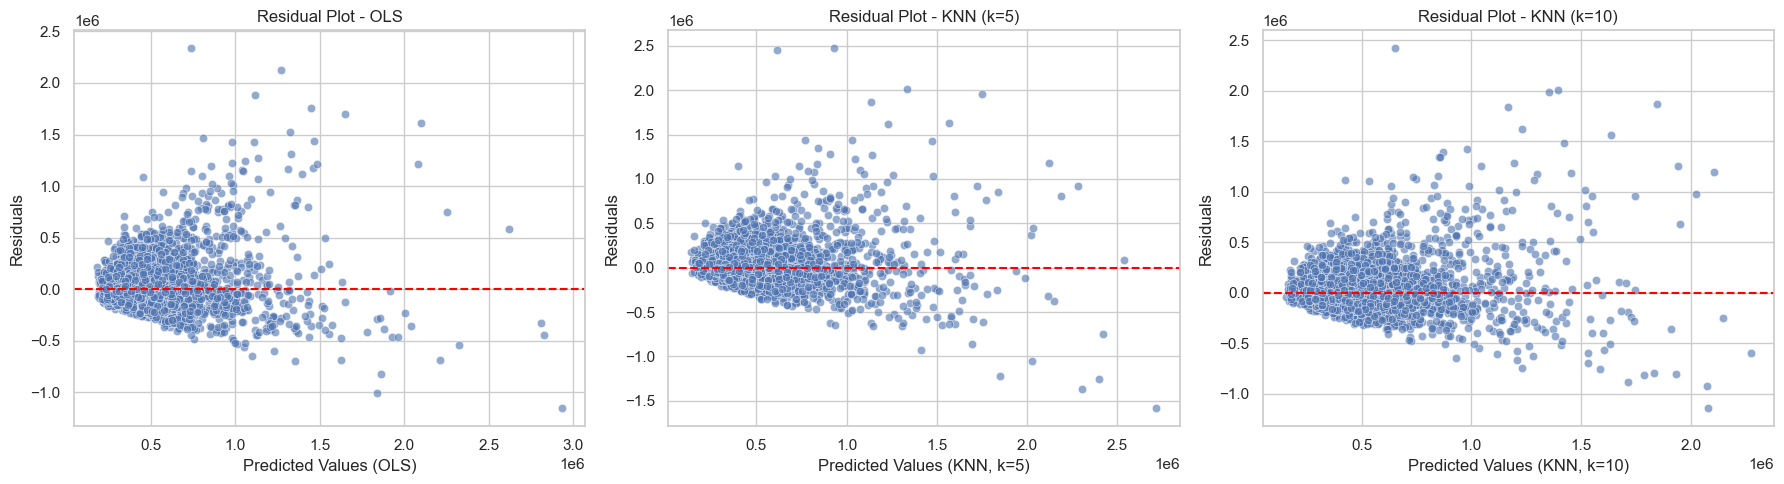

In [111]:
# Residuals calculation
ols_residuals = normal_y_test - normal_predicted_price_test   # Replace with predictions from your OLS model
knn5_residuals = normal_y_test - knn_pred_y_test # Replace with predictions from your KNN (k=5) model
knn10_residuals = normal_y_test - knn_pred_y_test_2 # Replace with predictions from your KNN (k=10) model

# Create subplots
plt.figure(figsize=(18, 5))

# OLS residual plot
plt.subplot(1, 3, 1)
sns.scatterplot(x=normal_predicted_price_test, y=ols_residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
plt.xlabel('Predicted Values (OLS)')
plt.ylabel('Residuals')
plt.title('Residual Plot - OLS')

# KNN with k=5 residual plot
plt.subplot(1, 3, 2)
sns.scatterplot(x=knn_pred_y_test, y=knn5_residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
plt.xlabel('Predicted Values (KNN, k=5)')
plt.ylabel('Residuals')
plt.title('Residual Plot - KNN (k=5)')

# KNN with k=10 residual plot
plt.subplot(1, 3, 3)
sns.scatterplot(x=knn_pred_y_test_2, y=knn10_residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
plt.xlabel('Predicted Values (KNN, k=10)')
plt.ylabel('Residuals')
plt.title('Residual Plot - KNN (k=10)')

plt.tight_layout()
plt.show()